In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io
import random
from collections import defaultdict
import math
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from sklearn.metrics import precision_score, recall_score
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from os import listdir
import pickle
from sklearn.manifold import TSNE

In [2]:
def get_mets(file_path):
    mat = scipy.io.loadmat(file_path)
    model = mat['model'][0][0]
    
    met_list = model[5]
    return set([met[0][0] for met in met_list])

In [3]:
def get_rxns(file_path):
    mat = scipy.io.loadmat(file_path)
    model = mat['model'][0][0]
    
    rxn_list = model[0]
    
    return set([rxn[0][0] for rxn in rxn_list])

In [151]:
def mat_to_network(file_path):
    global rxn_rev
#     global rxn_bac_gene_dict
    
    mat = scipy.io.loadmat(file_path)
    model = mat['model'][0][0]
    
    rxn_list = model[0]
    met_list = model[5]
    gene_list = model[8]
    rxn_met_mat = model[1].tocoo()
#     rxn_gene_mat = model[11].tocoo()    

    rxn_gene_dict = defaultdict(list)
    rxn_met_dict = {}

#     for rxn, gene in zip(rxn_gene_mat.row, rxn_gene_mat.col):
#         if rxn_list[rxn][0][0] in rxn_bac_gene_dict:
#             rxn_bac_gene_dict[rxn_list[rxn][0][0]][file_path].append(gene_list[gene][0][0])
#         else:
#             rxn_bac_gene_dict[rxn_list[rxn][0][0]][file_path] = [gene_list[gene][0][0]]

#         rxn_gene_dict[rxn_list[rxn][0][0]].append(gene_list[gene][0][0])
        
    for met, rxn, coeff in zip(rxn_met_mat.row, rxn_met_mat.col, rxn_met_mat.data):
        
        if rxn_list[rxn][0][0] in rxn_rev:
            if rxn_rev[rxn_list[rxn][0][0]]:
                if rxn_list[rxn][0][0] in rxn_met_dict:
                    rxn_met_dict[rxn_list[rxn][0][0]]['substrates'].append((met_list[met][0][0],abs(coeff)))
                    rxn_met_dict[rxn_list[rxn][0][0]]['products'].append((met_list[met][0][0],abs(coeff)))
                else:
                    rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[(met_list[met][0][0],abs(coeff))],'products':[(met_list[met][0][0],abs(coeff))]}

            else:
                if rxn_list[rxn][0][0] in rxn_met_dict:
                    if coeff < 0:
                        rxn_met_dict[rxn_list[rxn][0][0]]['substrates'].append((met_list[met][0][0],-coeff))
                    else:
                        rxn_met_dict[rxn_list[rxn][0][0]]['products'].append((met_list[met][0][0],coeff))
                else:
                    if coeff < 0:
                        rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[(met_list[met][0][0],-coeff)],'products':[]}
                    else:
                        rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[],'products':[(met_list[met][0][0],coeff)]}
            continue
        
        document = client.get('https://www.vmh.life/_api/reactions/?abbreviation='+rxn_list[rxn][0][0])
        rxn_rev[rxn_list[rxn][0][0]] = '<=>' in document['results'][0]['formula']
        
        if '<=>' in document['results'][0]['formula']:
            if rxn_list[rxn][0][0] in rxn_met_dict:
                rxn_met_dict[rxn_list[rxn][0][0]]['substrates'].append((met_list[met][0][0],abs(coeff)))
                rxn_met_dict[rxn_list[rxn][0][0]]['products'].append((met_list[met][0][0],abs(coeff)))
            else:
                rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[(met_list[met][0][0],abs(coeff))],'products':[(met_list[met][0][0],abs(coeff))]}        
        
        else:
            if rxn_list[rxn][0][0] in rxn_met_dict:
                if coeff < 0:
                    rxn_met_dict[rxn_list[rxn][0][0]]['substrates'].append((met_list[met][0][0],-coeff))
                else:
                    rxn_met_dict[rxn_list[rxn][0][0]]['products'].append((met_list[met][0][0],coeff))
            else:
                if coeff < 0:
                    rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[(met_list[met][0][0],-coeff)],'products':[]}
                else:
                    rxn_met_dict[rxn_list[rxn][0][0]] = {'substrates':[],'products':[(met_list[met][0][0],coeff)]}
                
    met_rxn_network = nx.DiGraph()

    for rxn in rxn_met_dict:
        sl = rxn_met_dict[rxn]['substrates']
        pl = rxn_met_dict[rxn]['products']
        
        # skip reaction if one of the fields is missing
        
        if not (sl and pl):
            continue

        for s in sl:
            s_id, s_coef = s
            met_rxn_network.add_edge(s_id,rxn, coef=s_coef)

        for p in pl:
            p_id, p_coef = p
            met_rxn_network.add_edge(rxn,p_id, coef=s_coef)
    
    return met_rxn_network

In [ ]:
all_rxns = set()
all_mets = set()
bacs = {}

all_files = sorted(listdir('./reconstructions/mat/'))

problems = ['.DS_Store','Roseburia_hominis_A2_183.mat']#['Roseburia_hominis_A2_183',,'.DS_Store','Ruminococcus_sp_18P13','Ruminococcus_sp_18P13.mat']

for file in all_files:
    print(file[:-4])
    
    if file in problems:
        continue
    
    file_path = './reconstructions/mat/'+file
    
    rxns = get_rxns(file_path)
    mets = get_mets(file_path)
        
    bacs[file[:-4]] = (rxns,mets)

In [144]:
with open('all_bacs.pickle', 'wb') as handle:
    pickle.dump(bacs, handle)

In [145]:
all_rxns = set()
all_mets = set()

for bac,data in bacs.items():
    all_rxns.update(data[0])
    all_mets.update(data[1])
    
print(len(all_rxns))
print(len(all_mets))

5417
2473


In [146]:
np.save('all_rxns.npy',sorted(list(all_rxns)))
np.save('all_mets.npy',sorted(list(all_mets)))

In [ ]:
all_rxns = np.load('Generated_Data/all_rxns.npy')
all_mets = np.load('Generated_Data/all_mets.npy')
all_bacs = pickle.load( open( "Generated_Data/all_bacs.pickle", "rb" ) )

In [96]:
bac_rxn_ind = {}
bac_met_ind = {}

In [97]:
for bac,data in all_bacs.items():
    bac_rxn_ind[bac] = [rxn in data[0] for rxn in all_rxns]
    bac_met_ind[bac] = [met in data[1] for met in all_mets]

In [98]:
with open('bac_rxn_ind.pickle', 'wb') as handle:
    pickle.dump(bac_rxn_ind, handle)
with open('bac_met_ind.pickle', 'wb') as handle:
    pickle.dump(bac_met_ind, handle)

# Taxonomy Data

### Get taxonomy for each microbe reconstruction

In [5]:
tax = pd.read_csv('Data/microbes_taxonomy.tsv',sep='\t')
#tax.head()

In [6]:
# find the microbe with the highest reaction count for each phylum, class, order, family and genus

p_max = {}
c_max = {}
o_max = {}
f_max = {}
g_max = {}

for i,row in tax.iterrows():
    p, c, o, f, g = row[['phylum','mclass','order','family','genus']]
    org = row['organism']
    rxn_count = row['reactions']
    
    if p in p_max:
        if p_max[p]['rxn_count'] < rxn_count:
            p_max[p]['rxn_count'] = rxn_count
            p_max[p]['name'] = org
    else:
        p_max[p] = {'name':org, 'rxn_count':rxn_count}
        
    if c in c_max:
        if c_max[c]['rxn_count'] < rxn_count:
            c_max[c]['rxn_count'] = rxn_count
            c_max[c]['name'] = org
    else:
        c_max[c] = {'name':org, 'rxn_count':rxn_count}
        
    if o in o_max:
        if o_max[o]['rxn_count'] < rxn_count:
            o_max[o]['rxn_count'] = rxn_count
            o_max[o]['name'] = org
    else:
        o_max[o] = {'name':org, 'rxn_count':rxn_count}
        
    if f in f_max:
        if f_max[f]['rxn_count'] < rxn_count:
            f_max[f]['rxn_count'] = rxn_count
            f_max[f]['name'] = org
    else:
        f_max[f] = {'name':org, 'rxn_count':rxn_count}
        
    if g in g_max:
        if g_max[g]['rxn_count'] < rxn_count:
            g_max[g]['rxn_count'] = rxn_count
            g_max[g]['name'] = org
    else:
        g_max[g] = {'name':org, 'rxn_count':rxn_count}

# Cooccurrence

### Parse co-occurrence dataset and find appropriate microbes

In [7]:
co_occ = pd.read_excel('Data/co-occurrence.XLSX')

In [8]:
co_occ = co_occ[['Clade 1','Clade 2','Direction']]
co_occ['microbe 1'] = None
co_occ['file path 1'] = None
co_occ['microbe 2'] = None
co_occ['file path 2'] = None

co_occ = co_occ[np.logical_or(co_occ['Direction']<=-2,co_occ['Direction']>=2)]

for i,row in co_occ.iterrows():
    t1 = row['Clade 1'].split('-')
    t1 = t1[0] if t1[1] == 'unclassified' else t1[1]
    t2 = row['Clade 2'].split('-')
    t2 = t2[0] if t2[1] == 'unclassified' else t2[1]
    
    m1 = None
    m2 = None
    
    # use the most specific microbe available with the given info
    
    if t1 in p_max:
        m1 = p_max[t1]['name']
    if t1 in c_max:
        m1 = c_max[t1]['name']
    if t1 in o_max:
        m1 = o_max[t1]['name']
    if t1 in f_max:
        m1 = f_max[t1]['name']
    if t1 in g_max:
        m1 = g_max[t1]['name']
        
    if t2 in p_max:
        m2 = p_max[t2]['name']
    if t2 in c_max:
        m2 = c_max[t2]['name']
    if t2 in o_max:
        m2 = o_max[t2]['name']
    if t2 in f_max:
        m2 = f_max[t2]['name']
    if t2 in g_max:
        m2 = g_max[t2]['name']
        
    if m1 and m2:
        f1 = './reconstructions/mat/' + re.sub('[^0-9a-zA-Z]+', '_', m1) + '.mat'
        f2 = './reconstructions/mat/' + re.sub('[^0-9a-zA-Z]+', '_', m2) + '.mat'
        co_occ.loc[i,['microbe 1','file path 1','microbe 2','file path 2']] = [m1,f1,m2,f2]

In [9]:
co_occ = co_occ.dropna()
co_occ = co_occ[co_occ['microbe 1']!=co_occ['microbe 2']]

In [10]:
# rxn to bacteria-gene pair list dict
rxn_bac_gene_dict = defaultdict(dict)

### Number of pairs in the dataset

In [11]:
s = set()
for m_pair in zip(co_occ['microbe 1'],co_occ['microbe 2']):
    if m_pair[0]!=m_pair[1]:
        s.add(tuple(sorted(m_pair)))
len(s)

440

In [12]:
min(co_occ['Direction'])

-6

In [13]:
np.mean(co_occ['Direction']<=0)

0.5818798449612403

### Prepare data for indicator encoding of reactions

In [14]:
co_occ_X = []
co_occ_y = []

rxn_set = set()

bacs = {}

pairs_collected = set()

for i,row in co_occ.iterrows():
    if tuple(sorted([row['microbe 1'],row['microbe 2']])) in pairs_collected:
        continue
    else:
        pairs_collected.add(tuple(sorted([row['microbe 1'],row['microbe 2']])))
    if row['microbe 1'] not in bacs:
        bacs[row['microbe 1']] = get_rxns(row['file path 1'])
        rxn_set.update(bacs[row['microbe 1']])
    if row['microbe 2'] not in bacs:
        bacs[row['microbe 2']] = get_rxns(row['file path 2'])
        rxn_set.update(bacs[row['microbe 2']])
    
print('all reactions collected')

rxn_list = sorted(list(rxn_set))

pairs_collected = set()

for i,row in co_occ.iterrows():
    if tuple(sorted([row['microbe 1'],row['microbe 2']])) in pairs_collected:
        continue
    else:
        pairs_collected.add(tuple(sorted([row['microbe 1'],row['microbe 2']])))
    x_1 = np.array([rxn in bacs[row['microbe 1']] for rxn in rxn_list])
    x_2 = np.array([rxn in bacs[row['microbe 2']] for rxn in rxn_list])
    y = row['Direction']
    co_occ_X.append(np.logical_or(x_1,x_2))
    co_occ_y.append(y)
    if len(co_occ_y) % 100 == 0:
        print(len(co_occ_y))
    
print('data set constructed')

all reactions collected
100
200
300
400
data set constructed


In [ ]:
np.save('co_occ_X',co_occ_X)
np.save('co_occ_y',co_occ_y)

### Compare with AGORA Pairwise Growth Data

In [15]:
co_occ.head()

,Clade 1,Clade 2,Direction,microbe 1,file path 1,microbe 2,file path 2
0,Staphylococcaceae-Gemella,Veillonellaceae-Megasphaera,-2,Gemella sanguinis ATCC700632,./reconstructions/mat/Gemella_sanguinis_ATCC70...,Megasphaera elsdenii DSM 20460,./reconstructions/mat/Megasphaera_elsdenii_DSM...
1,Staphylococcaceae-Gemella,Prevotellaceae-Prevotella,-3,Gemella sanguinis ATCC700632,./reconstructions/mat/Gemella_sanguinis_ATCC70...,Prevotella salivae DSM 15606,./reconstructions/mat/Prevotella_salivae_DSM_1...
2,Staphylococcaceae-Gemella,Flavobacteriaceae-unclassified,2,Gemella sanguinis ATCC700632,./reconstructions/mat/Gemella_sanguinis_ATCC70...,Capnocytophaga sputigena ATCC 33612,./reconstructions/mat/Capnocytophaga_sputigena...
3,Staphylococcaceae-Gemella,Bacteroidales-Prevotellaceae,-3,Gemella sanguinis ATCC700632,./reconstructions/mat/Gemella_sanguinis_ATCC70...,Prevotella salivae DSM 15606,./reconstructions/mat/Prevotella_salivae_DSM_1...
4,Staphylococcaceae-Gemella,Firmicutes-Clostridia,-3,Gemella sanguinis ATCC700632,./reconstructions/mat/Gemella_sanguinis_ATCC70...,Clostridium celatum DSM 1785,./reconstructions/mat/Clostridium_celatum_DSM_...


# Pairwise growth rate data

In [69]:
pairwise = pd.read_excel('Data/pairwise_S9.xlsx')

In [17]:
pairwise['WD An Ratio'] = 0
pairwise['WD Ae Ratio'] = 0
pairwise['HFD An Ratio'] = 0
pairwise['HFD Ae Ratio'] = 0

### WARNING: takes very long to run

In [18]:
for i,row in pairwise.iterrows():
    pairwise.loc[i,'WD An Ratio'] = min(row['WesternDietAnaerobic_Strain1'],row['WesternDietAnaerobic_Strain2'])/max(row['WesternDietAnaerobic_Strain1'],row['WesternDietAnaerobic_Strain2'])
    pairwise.loc[i,'WD Ae Ratio'] = min(row['WesternDietAerobic_Strain1'],row['WesternDietAerobic_Strain2'])/max(row['WesternDietAerobic_Strain1'],row['WesternDietAerobic_Strain2'])
    pairwise.loc[i,'HFD An Ratio'] = min(row['HighFiberDietAnaerobic_Strain1'],row['HighFiberDietAnaerobic_Strain2'])/max(row['HighFiberDietAnaerobic_Strain1'],row['HighFiberDietAnaerobic_Strain2'])
    pairwise.loc[i,'HFD Ae Ratio'] = min(row['HighFiberDietAerobic_Strain1'],row['HighFiberDietAerobic_Strain2'])/max(row['HighFiberDietAerobic_Strain1'],row['HighFiberDietAerobic_Strain2'])

In [19]:
pairwise.head()

,Strain1,Strain2,MetabolicDistance,WesternDietAnaerobic_Strain1,WesternDietAnaerobic_Strain2,WesternDietAerobic_Strain1,WesternDietAerobic_Strain2,HighFiberDietAnaerobic_Strain1,HighFiberDietAnaerobic_Strain2,HighFiberDietAerobic_Strain1,HighFiberDietAerobic_Strain2,WD An Ratio,WD Ae Ratio,HFD An Ratio,HFD Ae Ratio
0,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_fermentans_DSM_20731,0.506916,0.083975,0.323212,0.102995,0.367884,0.150243,0.228819,0.179257,0.228819,0.259815,0.279965,0.656602,0.783401
1,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_intestini_RyC_MR95,0.490856,0.235220,0.389636,0.242811,0.443023,0.231492,0.403192,0.229546,0.432670,0.603693,0.548077,0.574149,0.530534
2,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_sp_D21,0.534351,0.181236,0.091164,0.194221,0.132466,0.177800,0.096361,0.191920,0.122726,0.503013,0.682040,0.541963,0.639462
3,Abiotrophia_defectiva_ATCC_49176,Acinetobacter_calcoaceticus_PHEA_2,0.539700,0.125950,0.447691,0.115378,1.220015,0.148777,0.397997,0.155532,1.166038,0.281331,0.094571,0.373814,0.133385
4,Abiotrophia_defectiva_ATCC_49176,Acinetobacter_haemolyticus_NIPH_261,0.521845,0.033281,0.363215,0.414591,0.457639,0.134721,0.228819,0.496263,0.228819,0.091628,0.905936,0.588764,0.461085


In [ ]:
co_occ_dict = {}

for i, row in co_occ.iterrows():
    pair = tuple(sorted([row['file path 1'][22:-4],row['file path 2'][22:-4]]))
    co_occ_dict[pair] = row['Direction']
    
pairwise_dict = {}

for i, row in pairwise.iterrows():
    if i % 10000 == 0:
        print(i)
    pair = tuple([row['Strain1'],row['Strain2']])
    pairwise_dict[pair] = row[['MetabolicDistance','WD An Ratio','WD Ae Ratio','HFD An Ratio','HFD Ae Ratio']]


In [21]:
directions = []
ratios = {'MetabolicDistance':[],'WD An Ratio':[],'WD Ae Ratio':[],'HFD An Ratio':[],'HFD Ae Ratio':[]}

for pair,direction in co_occ_dict.items():
    if pair in pairwise_dict:
        directions.append(direction)
        for attr in ratios.keys():
            ratios[attr].append(pairwise_dict[pair][attr])

In [23]:
with open('pairwise_growth.pickle', 'wb') as handle:
    pickle.dump(ratios, handle)

In [24]:
with open('pairwise_coocc.pickle', 'wb') as handle:
    pickle.dump(directions, handle)

Text(0.5, 0, 'Cooccurrence Direction')

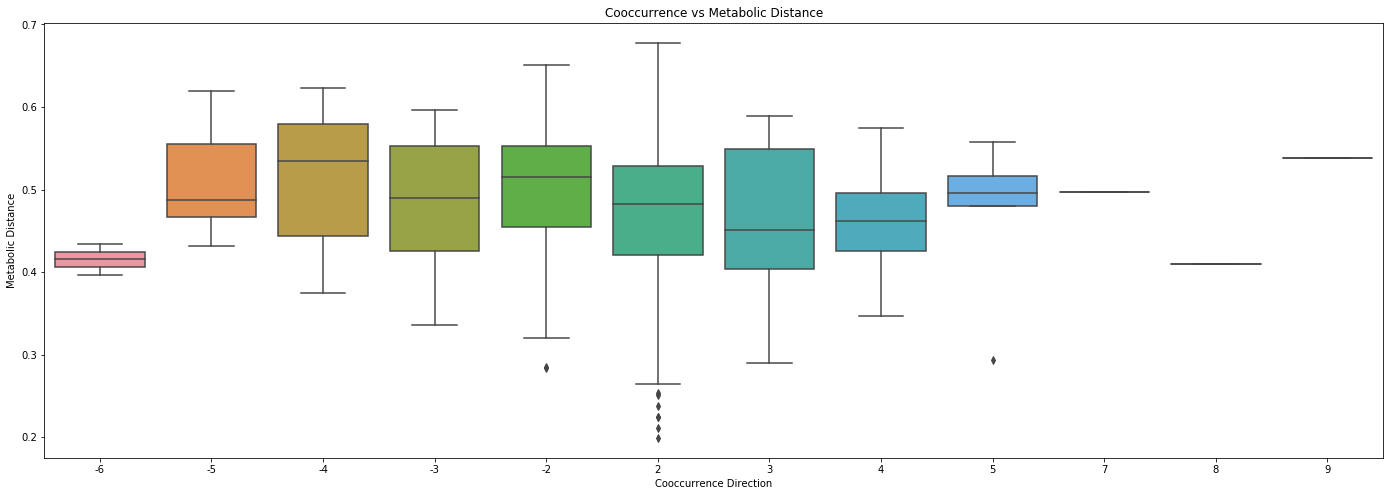

In [22]:
_, ax = plt.subplots(figsize=(24,8))

sns.boxplot(directions,ratios['MetabolicDistance'],ax=ax)
ax.set_title('Cooccurrence vs Metabolic Distance')
ax.set_ylabel('Metabolic Distance')
ax.set_xlabel('Cooccurrence Direction')

In [25]:
print('Pearson Correlation: ', end='')
print(np.corrcoef(ratios['MetabolicDistance'],directions)[0,1])

lr = linear_model.LinearRegression()

lr.fit(np.array(ratios['MetabolicDistance']).reshape(-1,1),directions)
print('r^2: '+str(lr.score(np.array(ratios['MetabolicDistance']).reshape(-1,1),directions)))

Pearson Correlation: -0.17312774539902231
r^2: 0.029973216226948485


Text(0, 0.5, 'Log Ratio')

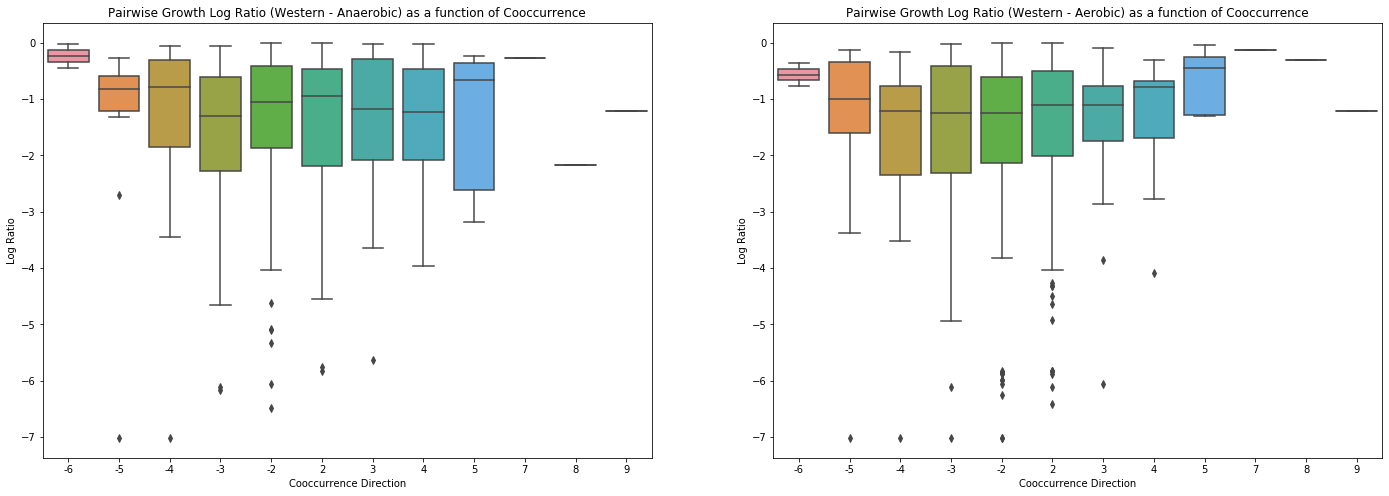

In [26]:
_, axes = plt.subplots(1,2,figsize=(24,8))

sns.boxplot(directions,np.log(ratios['WD An Ratio']),ax=axes[0])
axes[0].set_title('Pairwise Growth Log Ratio (Western - Anaerobic) as a function of Cooccurrence')
axes[0].set_xlabel('Cooccurrence Direction')
axes[0].set_ylabel('Log Ratio')

sns.boxplot(directions,np.log(ratios['WD Ae Ratio']),ax=axes[1])
axes[1].set_title('Pairwise Growth Log Ratio (Western - Aerobic) as a function of Cooccurrence')
axes[1].set_xlabel('Cooccurrence Direction')
axes[1].set_ylabel('Log Ratio')

In [27]:
print('Left:')
print('Pearson Correlation: ', end='')
print(np.corrcoef(np.log(ratios['WD An Ratio']),directions)[0,1])

lr = linear_model.LinearRegression()

lr.fit(np.log(np.array(ratios['WD An Ratio'])).reshape(-1,1),directions)
print('r^2: '+str(lr.score(np.log(np.array(ratios['WD An Ratio'])).reshape(-1,1),directions)))

print('Right:')
print('Pearson Correlation: ', end='')
print(np.corrcoef(np.log(ratios['WD Ae Ratio']),directions)[0,1])

lr = linear_model.LinearRegression()

lr.fit(np.log(np.array(ratios['WD Ae Ratio'])).reshape(-1,1),directions)
print('r^2: '+str(lr.score(np.log(np.array(ratios['WD Ae Ratio'])).reshape(-1,1),directions)))

Left:
Pearson Correlation: 0.020584302008161345
r^2: 0.00042371348916314666
Right:
Pearson Correlation: 0.0794381500036905
r^2: 0.0063104196760086495


### Cooccurrence and pairwise growth ratio are more correlated in an aerobic setting?

Text(0, 0.5, 'Log Ratio')

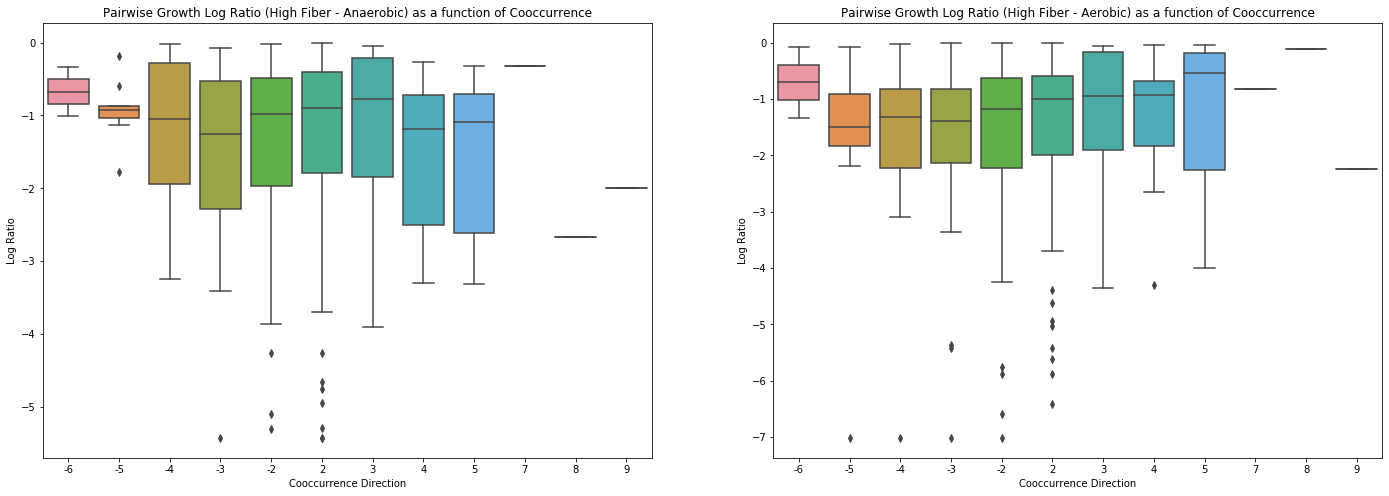

In [28]:
_, axes = plt.subplots(1,2,figsize=(24,8))

sns.boxplot(directions,np.log(ratios['HFD An Ratio']),ax=axes[0])
axes[0].set_title('Pairwise Growth Log Ratio (High Fiber - Anaerobic) as a function of Cooccurrence')
axes[0].set_xlabel('Cooccurrence Direction')
axes[0].set_ylabel('Log Ratio')

sns.boxplot(directions,np.log(ratios['HFD Ae Ratio']),ax=axes[1])
axes[1].set_title('Pairwise Growth Log Ratio (High Fiber - Aerobic) as a function of Cooccurrence')
axes[1].set_xlabel('Cooccurrence Direction')
axes[1].set_ylabel('Log Ratio')

In [29]:
print('Left:')
print('Pearson Correlation: ', end='')
print(np.corrcoef(np.log(ratios['HFD An Ratio']),directions)[0,1])

lr = linear_model.LinearRegression()

lr.fit(np.log(np.array(ratios['HFD An Ratio'])).reshape(-1,1),directions)
print('r^2: '+str(lr.score(np.log(np.array(ratios['HFD An Ratio'])).reshape(-1,1),directions)))

print('Right:')
print('Pearson Correlation: ', end='')
print(np.corrcoef(np.log(ratios['HFD Ae Ratio']),directions)[0,1])

lr = linear_model.LinearRegression()

lr.fit(np.log(np.array(ratios['HFD Ae Ratio'])).reshape(-1,1),directions)
print('r^2: '+str(lr.score(np.log(np.array(ratios['HFD Ae Ratio'])).reshape(-1,1),directions)))

Left:
Pearson Correlation: -0.027091573954849846
r^2: 0.0007339533793510044
Right:
Pearson Correlation: 0.08244438500816019
r^2: 0.0067970766193736765


### Prepare pairwise data with indicator rxn vector

In [ ]:
pairwise_WDAn_X = []
pairwise_WDAn_y = []

rxn_set = set()

bacs = {}
pairs = {}

all_files = [file[:-4] for file in listdir('./reconstructions/mat/')]

problems = ['Roseburia_hominis_A2_183','.DS_Store']

In [ ]:
for i,row in pairwise.iterrows():
    if i%10000 == 0:
        print(i)
    if not (row['Strain1'] in all_files and row['Strain2'] in all_files) or (row['Strain1'] in problems or row['Strain2'] in problems):
        continue
    if row['Strain1'] not in bacs:
        print(row['Strain1'])
        bacs[row['Strain1']] = get_rxns('./reconstructions/mat/'+row['Strain1']+'.mat')
        rxn_set.update(bacs[row['Strain1']])
    if row['Strain2'] not in bacs:
        print(row['Strain2'])
        bacs[row['Strain2']] = get_rxns('./reconstructions/mat/'+row['Strain2']+'.mat')
        rxn_set.update(bacs[row['Strain2']])
    pairs[(row['Strain1'],row['Strain2'])] = (bacs[row['Strain1']].union(bacs[row['Strain2']]),row['WD An Ratio'])
    
print('all reactions collected')

rxn_list = sorted(list(rxn_set))

for pair, data in pairs.items():
    x = np.array([rxn in data[0] for rxn in rxn_list])
    y = data[1]
    pairwise_WDAn_X.append(x)
    pairwise_WDAn_y.append(y)
    if len(pairwise_WDAn_y) % 10000 == 0:
        print(len(co_occ_y))
    
print('data set constructed')

In [ ]:
mean = np.mean(pairwise_WDAn_y)
mean

In [ ]:
std = np.std(pairwise_WDAn_y)
std

In [ ]:
np.save('pairwise_WDAn_X',pairwise_WDAn_X)
np.save('pairwise_WDAn_y',pairwise_WDAn_y)

# Growth Rates

In [52]:
growth = pd.read_excel('Data/growth_rates_S6.xlsx')
growth.head()

,AGORA Strain,Model ID,"Western diet, anaerobic (h-1)","Western diet, aerobic (h-1)","High fiber diet, anaerobic (h-1)","High fiber diet, aerobic (h-1)"
0,Abiotrophia defectiva ATCC 49176,Abiotrophia_defectiva_ATCC_49176,0.149475,0.167712,0.164658,0.171042
1,Acidaminococcus fermentans DSM 20731,Acidaminococcus_fermentans_DSM_20731,0.190554,0.215615,0.151478,0.171014
2,Acidaminococcus intestini RyC-MR95,Acidaminococcus_intestini_RyC_MR95,0.122018,0.122468,0.111260,0.111670
3,Acidaminococcus sp. D21,Acidaminococcus_sp_D21,0.122922,0.123365,0.117347,0.117770
4,Acinetobacter calcoaceticus PHEA-2,Acinetobacter_calcoaceticus_PHEA_2,0.244252,1.018836,0.325669,1.103735


In [53]:
growth_dict = {}

In [54]:
for i,row in growth.iterrows():
    growth_dict[row['Model ID']] = (row['Western diet, anaerobic (h-1)'],row['Western diet, aerobic (h-1)'],row['High fiber diet, anaerobic (h-1)'],row['High fiber diet, aerobic (h-1)'])

In [ ]:
for i,row in pairwise.iterrows():
    if i % 10000 == 0:
        print(i)
    pairwise.loc[i,'WD An Ratio'] = row['WesternDietAnaerobic_Strain1']/row['WesternDietAnaerobic_Strain2']
    pairwise.loc[i,'WD Ae Ratio'] = row['WesternDietAerobic_Strain1']/row['WesternDietAerobic_Strain2']
    pairwise.loc[i,'HFD An Ratio'] = row['HighFiberDietAnaerobic_Strain1']/row['HighFiberDietAnaerobic_Strain2']
    pairwise.loc[i,'HFD Ae Ratio'] = row['HighFiberDietAerobic_Strain1']/row['HighFiberDietAerobic_Strain2']
    pairwise.loc[i,'S6 WD An Growth Ratio'] = growth_dict[row['Strain1']][0]/growth_dict[row['Strain2']][0]
    pairwise.loc[i,'S6 WD Ae Growth Ratio'] = growth_dict[row['Strain1']][1]/growth_dict[row['Strain2']][1]
    pairwise.loc[i,'S6 HFD An Growth Ratio'] = growth_dict[row['Strain1']][2]/growth_dict[row['Strain2']][2]
    pairwise.loc[i,'S6 HFD Ae Growth Ratio'] = growth_dict[row['Strain1']][3]/growth_dict[row['Strain2']][3]

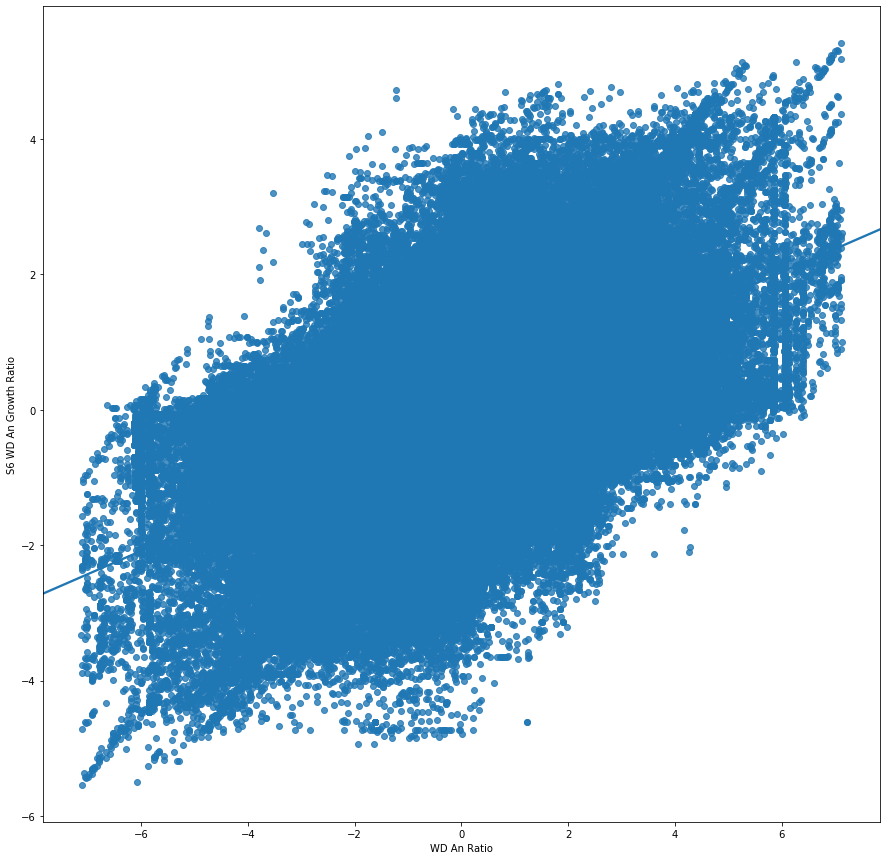

In [137]:
_, ax = plt.subplots(figsize=(15,15))
sample = random.sample(list(range(298378)),298378)
sns.regplot(np.log(pairwise['WD An Ratio'][sample]),np.log(pairwise['S6 WD An Growth Ratio'][sample]),ax=ax)

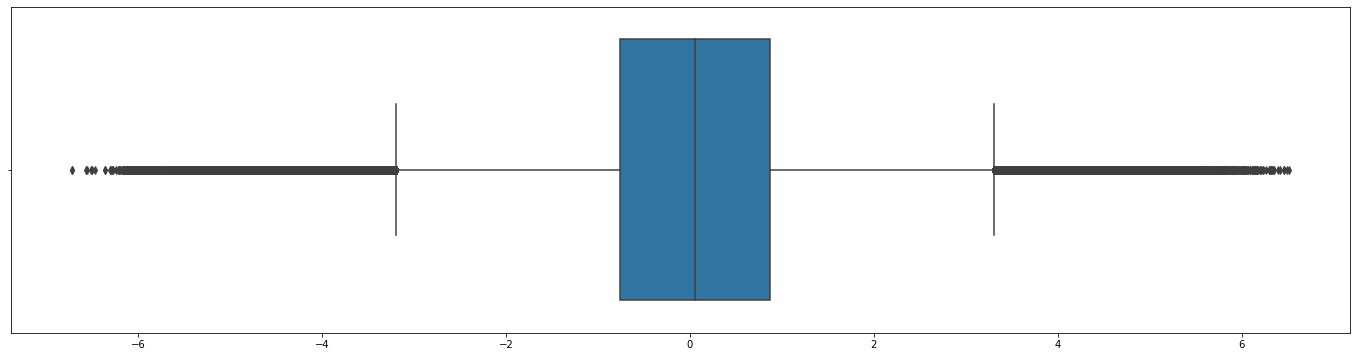

In [134]:
_, ax = plt.subplots(figsize=(24,6))
sns.boxplot(np.log(pairwise['WD An Ratio'][sample]/pairwise['S6 WD An Growth Ratio'][sample]),ax=ax)

In [ ]:
for i,row in pairwise.iterrows():
    if i % 10000 == 0:
        print(i)
    pairwise.loc[i,'S6 WD An 1'] = growth_dict[row['Strain1']][0]
    pairwise.loc[i,'S6 WD An 2'] = growth_dict[row['Strain2']][0]
    pairwise.loc[i,'S6 WD Ae 1'] = growth_dict[row['Strain1']][1]
    pairwise.loc[i,'S6 WD Ae 2'] = growth_dict[row['Strain2']][1]
    pairwise.loc[i,'S6 HFD An 1'] = growth_dict[row['Strain1']][2]
    pairwise.loc[i,'S6 HFD An 2'] = growth_dict[row['Strain2']][2]
    pairwise.loc[i,'S6 HFD Ae 1'] = growth_dict[row['Strain1']][3]
    pairwise.loc[i,'S6 HFD Ae 2'] = growth_dict[row['Strain2']][3]

In [71]:
pairwise.head()

,Strain1,Strain2,MetabolicDistance,WesternDietAnaerobic_Strain1,WesternDietAnaerobic_Strain2,WesternDietAerobic_Strain1,WesternDietAerobic_Strain2,HighFiberDietAnaerobic_Strain1,HighFiberDietAnaerobic_Strain2,HighFiberDietAerobic_Strain1,HighFiberDietAerobic_Strain2,S6 WD An 1,S6 WD An 2,S6 WD Ae 1,S6 WD Ae 2,S6 HFD An 1,S6 HFD An 2,S6 HFD Ae 1,S6 HFD Ae 2
0,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_fermentans_DSM_20731,0.506916,0.083975,0.323212,0.102995,0.367884,0.150243,0.228819,0.179257,0.228819,0.149475,0.190554,0.167712,0.215615,0.164658,0.151478,0.171042,0.171014
1,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_intestini_RyC_MR95,0.490856,0.235220,0.389636,0.242811,0.443023,0.231492,0.403192,0.229546,0.432670,0.149475,0.122018,0.167712,0.122468,0.164658,0.111260,0.171042,0.111670
2,Abiotrophia_defectiva_ATCC_49176,Acidaminococcus_sp_D21,0.534351,0.181236,0.091164,0.194221,0.132466,0.177800,0.096361,0.191920,0.122726,0.149475,0.122922,0.167712,0.123365,0.164658,0.117347,0.171042,0.117770
3,Abiotrophia_defectiva_ATCC_49176,Acinetobacter_calcoaceticus_PHEA_2,0.539700,0.125950,0.447691,0.115378,1.220015,0.148777,0.397997,0.155532,1.166038,0.149475,0.244252,0.167712,1.018836,0.164658,0.325669,0.171042,1.103735
4,Abiotrophia_defectiva_ATCC_49176,Acinetobacter_haemolyticus_NIPH_261,0.521845,0.033281,0.363215,0.414591,0.457639,0.134721,0.228819,0.496263,0.228819,0.149475,0.129391,0.167712,0.457639,0.164658,0.162202,0.171042,0.228819


In [72]:
pairwise.to_csv('pairwise_w_growth.csv')

# Vitamin B

In [47]:
all_files = sorted([file[:-4] for file in listdir('./reconstructions/mat/')])
#print(all_files)

In [49]:
vitb = pd.read_excel('Data/vitB_S18.xlsx')
#vitb.head()

In [49]:
#!python3 node2vec-master/src/main.py --input node2vec-master/graph/karate.edgelist --output node2vec-master/emb/karate.emd --iter 10

### Create metabolite-reaction network of all AGORA reconstructions in VitB dataset

In [50]:
reactionset = set()
metaboliteset = set()
all_files = sorted([file[:-4] for file in listdir('./reconstructions/mat/')])

big_rxn_met_network = nx.DiGraph()

bacs = {}

problems = ['Roseburia_hominis_A2_183','Roseburia_hominis_A2_183.mat','.DS_S','Ruminococcus_sp_18P13','Ruminococcus_sp_18P13.mat']

for i, row in vitb.iterrows():
    if i%100==0:
        print(i)
    
    if row['Model ID'] in problems:
        continue
    name = row['Model ID'] if row['Model ID'][-4:]!='.mat' else row['Model ID'][:-4]
    
    file_path = './reconstructions/mat/'+name+'.mat'
    
    rxns = get_rxns(file_path)
    mets = get_mets(file_path)
        
    bac_network = mat_to_network(file_path)
    
    big_rxn_met_network = nx.compose(big_rxn_met_network,bac_network)
        
    reactionset.update(rxns)
    metaboliteset.update(mets)
    bacs[name] = (rxns,mets,list(row[['Biotin','Cobalamin','Folate','Niacin','Pantothenate','Pyridoxin','Riboflavin','Thiamin']]))

0
100
200
300
400
500


In [51]:
nx.write_gpickle(big_rxn_met_network, "big_rxn_met_network.gpickle")

In [52]:
with open('bacs.pickle', 'wb') as handle:
    pickle.dump(bacs, handle)

In [53]:
big_rxn_met_network = nx.read_gpickle('Generated_Data/big_rxn_met_network.gpickle')
bacs = pickle.load( open( "Generated_Data/bacs.pickle", "rb" ) )

In [54]:
reaction_list = sorted(list(reactionset))
metabolite_list = sorted(list(metaboliteset))

In [55]:
vitb_rxns_X = []
vitb_mets_X = []
vitb_y = []

for bac, data in bacs.items():
    rxns, mets, y = data
    
    vitb_rxns_X.append([rxn in rxns for rxn in reaction_list])
    vitb_mets_X.append([met in mets for met in metabolite_list])
    vitb_y.append(y)

In [56]:
np.save('vitb_rxns_X',vitb_rxns_X)
np.save('vitb_mets_X',vitb_mets_X)
np.save('vitb_y',vitb_y)

In [57]:
np.save('vitb_rxn_list',reaction_list)
np.save('vitb_met_list',metabolite_list)

In [58]:
reaction_dict_by_ind = dict(enumerate(reaction_list))
metabolite_dict_by_ind = dict(enumerate(metabolite_list,len(reaction_dict_by_ind)))

reaction_dict_by_rxn = {v:k for k,v in reaction_dict_by_ind.items()}
metabolite_dict_by_met = {v:k for k,v in metabolite_dict_by_ind.items()}

In [59]:
#run node2vec
#get subgraph representations
#run linreg, logreg, nn 

In [60]:
big_rxn_met_network_nos = nx.relabel.relabel_nodes(big_rxn_met_network,{**reaction_dict_by_rxn,**metabolite_dict_by_met})

In [ ]:
!pip install coreapi-cli

In [ ]:
!pip install coreapi

In [94]:
from coreapi import Client
client = Client()

In [155]:
rxn_rev = {}

In [156]:
all_files = sorted(listdir('./reconstructions/mat/'))

big_rxn_met_network = nx.DiGraph()

problems = ['.DS_Store','Roseburia_hominis_A2_183.mat']

In [ ]:
for i in range(len(all_files)):
    if i%20==0:
        print(i)
    file = all_files[i]
    
    if file in problems:
        continue
    
    file_path = './reconstructions/mat/'+file
    
    bac_network = mat_to_network(file_path)
    
    big_rxn_met_network = nx.compose(big_rxn_met_network,bac_network)

In [158]:
nx.write_gpickle(big_rxn_met_network, "all_bacs_rxnmet_network.gpickle")

### Generate Node2Vec Embeddings of Dimension 128

In [25]:
big_rxn_met_network = nx.read_gpickle('Generated_Data/all_bacs_rxnmet_network.gpickle')
mets = np.load('Generated_Data/all_mets.npy')
rxns = np.load('Generated_Data/all_rxns.npy')

In [100]:
len(mets)

2473

In [101]:
len(rxns)

5417

In [26]:
reaction_dict_by_ind = dict(enumerate(rxns))
metabolite_dict_by_ind = dict(enumerate(mets,len(reaction_dict_by_ind)))

reaction_dict_by_rxn = {v:k for k,v in reaction_dict_by_ind.items()}
metabolite_dict_by_met = {v:k for k,v in metabolite_dict_by_ind.items()}

In [99]:
with open('reaction_dict_by_ind.pickle', 'wb') as handle:
    pickle.dump(reaction_dict_by_ind, handle)
with open('metabolite_dict_by_ind.pickle', 'wb') as handle:
    pickle.dump(metabolite_dict_by_ind, handle)
with open('reaction_dict_by_rxn.pickle', 'wb') as handle:
    pickle.dump(reaction_dict_by_rxn, handle)
with open('metabolite_dict_by_met.pickle', 'wb') as handle:
    pickle.dump(metabolite_dict_by_met, handle)

In [27]:
big_rxn_met_network_nos = nx.relabel.relabel_nodes(big_rxn_met_network,{**reaction_dict_by_rxn,**metabolite_dict_by_met})

In [103]:
len(big_rxn_met_network)

7450

In [31]:
nx.write_edgelist(big_rxn_met_network_nos,'edgelist.txt',data=True)

In [42]:
with open('edgelist.txt','r') as old:
    with open('edgelist1.txt','w') as new:
        for line in old:
            edge1, edge2, _, weight = line.split()
            new.write(' '.join([edge1,edge2,weight[:-1]])+'\n')          

In [46]:
!python3 node2vec-master/src/main.py --input edgelist.txt --output embeddings.txt --iter 2 --q 2 --weighted

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


### t-SNE

In [11]:
reaction_dict_by_ind = pickle.load(open('Generated_Data/reaction_dict_by_ind.pickle','rb'))
metabolite_dict_by_ind = pickle.load(open('Generated_Data/metabolite_dict_by_ind.pickle','rb'))
all_rxns = np.load('Generated_Data/all_rxns.npy')
all_mets = np.load('Generated_Data/all_mets.npy')

In [12]:
embeddings = {}

with open('Generated_Data/embeddings.txt','r') as file:
    for line in file:
        node = int(line.split()[0])
        vec = np.array(line.split()[1:]).astype(np.float64)
        
        if node in reaction_dict_by_ind:
            embeddings[reaction_dict_by_ind[node]] = vec
        else:
            embeddings[metabolite_dict_by_ind[node]] = vec

In [13]:
tsne = TSNE()

In [30]:
rxn_embeddings = []

for name,emb in embeddings.items():
    if name in all_rxns:
        rxn_embeddings.append((name,emb))

met_embeddings = []

for name,emb in embeddings.items():
    if name in all_mets:
        met_embeddings.append((name,emb))

In [31]:
rxn_embeddings.sort(key=lambda t:t[0])
met_embeddings.sort(key=lambda t:t[0])

In [35]:
a = tsne.fit_transform([emb for name,emb in rxn_embeddings])

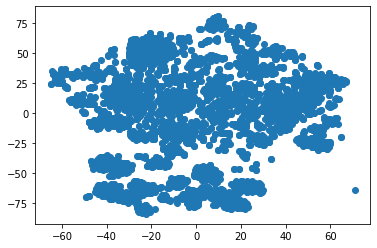

In [41]:
plt.scatter(a[:,0],a[:,1])